In [1]:
import pandas as pd
import numpy as np

## 데이터 로드

In [2]:
path = 'C:/SSAFY/3_특화프로젝트/data/'

In [3]:
theme_df = pd.read_csv(path+"mr_theme.csv", encoding='utf-8')
tg_df = pd.read_csv(path+"mr_themegenre.csv", encoding='utf-8')

## 최근 방문한 테마와 비슷한 테마 조회

### 로직

1. 사용자 선택
2. 사용자가 최근 방문한 테마 조회
3. 메타 데이터를 기반으로 테마 유사도를 계산한다
4. 유저 평점을 기반으로 테마 유사도를 계산한다
5. 테마 N개를 추출한다
6. DB 저장

### 1. 사용자 선택

### 2. 사용자가 최근 방문한 테마 조회

In [4]:
def get_recent_theme(user):
    return 1

### 3. 메타 데이터 기반 유사도 계산

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

#### 데이터 확인

In [6]:
theme_df.head(1)

,themeId,cafeId,poster,title,playtime,minPeople,maxPeople,level,tmpGenre,price,description,problemScore,storyScore,activityScore,fearScore
0,1,176,https://cdn.keigon.net/개꿀이스케이프/thumb_탈옥,탈옥,50,2,8,3.0,액션 범죄,11000,"평범한 한국사람, 푸에르트 로엘.\n어쩌다보니(?) 감옥에 갇혀버리고..\n""내가 ...",3.8,3.285714,0.272727,0.0


#### 데이터 전처리

- 각 열마다 최솟값과 최댓값이 다르기 때문에, Min-Max Scaling을 거쳐 정규화 해준다
- 장르는 다중 값을 가지기 때문에, 원-핫 인코딩을 이용해 벡터화한다 -> 다른 열들은 0~1의 값으로 정규화했기 때문에, 0,1이라는 장르 값이 들어가면 너무 가중될 것 같고, 값이 달라질 것 같음 => 별도 모델로 진행

In [20]:
target_features = [ 'level', 'problemScore', 'storyScore', 'activityScore', 'fearScore'] 
g_features = ['genre']

##### Min-Max Scaling

In [21]:
# Min-Max Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(theme_df[target_features])

##### 장르 벡터화

In [22]:
# 테마 별로 장르 집계
grouped_genres = tg_df.groupby('themeId')['genreId'].apply(list).reset_index()

In [23]:
# 원-핫 인코딩을 위해 MultiLabelBinarizer 사용
mlb = MultiLabelBinarizer()
encoded_genres = mlb.fit_transform(grouped_genres['genreId'])
encoded_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

#### 유사도 계산

In [67]:
# 가중치
normal_per = 0.2
genre_per = 0.8

##### 일반 데이터

In [68]:
similarity_normal = cosine_similarity(scaled_features)

##### 장르 

In [69]:
similarity_genre = cosine_similarity(encoded_genres)

In [70]:
final_similarity = similarity_normal*normal_per + similarity_genre*genre_per

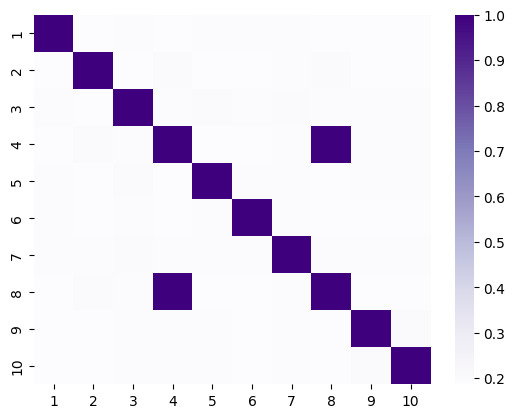

In [71]:
#sns.heatmap(similarity[:100, :100], xticklabels=theme_df['themeId'][:100], yticklabels=theme_df['themeId'][:100], cmap='ocean')
sns.heatmap(final_similarity[:10,:10], xticklabels=theme_df['themeId'][:10], yticklabels=theme_df['themeId'][:10], cmap='Purples')

plt.show()

#### 테스트

In [75]:
targetThemeId = 46

In [76]:
target_similarity = final_similarity[targetThemeId]
top_10_themes = np.argsort(-target_similarity)[:11]
top_10_themes = [idx for idx in top_10_themes if idx != targetThemeId]

In [77]:
# 결과 출력
top_10_similar_items = [(index, target_similarity[index]) for index in top_10_themes]
theme_title = theme_df.loc[targetThemeId-1, 'title']
print(f"대상 => ID: {targetThemeId}, 제목: {theme_title}")
print("상위 10개의 유사한 항목:")
for idx, sim in top_10_similar_items:
    theme_title = theme_df.loc[idx-1, 'title']
    print(f"ID: {idx}, 제목: {theme_title}, 유사도: {sim}")

대상 => ID: 46, 제목: 여신강림
상위 10개의 유사한 항목:
ID: 294, 제목: 파란지붕집, 유사도: 0.9998820397230774
ID: 952, 제목: 파라오의 석실, 유사도: 0.9995563470560933
ID: 1110, 제목: 냥이강쥐의 대모험, 유사도: 0.9993445717568555
ID: 696, 제목: 재즈 인 더 레인, 유사도: 0.9992689067432667
ID: 141, 제목: 리플레이, 유사도: 0.9991355692368172
ID: 766, 제목: 무한의 던전, 유사도: 0.9990728857872495
ID: 1288, 제목: 이상한 나라의 초대, 유사도: 0.9988895611777124
ID: 747, 제목: 지프리트의 심장, 유사도: 0.9988394323456091
ID: 1227, 제목: 수상한 병원, 유사도: 0.9988073621046352
ID: 254, 제목: 타짜, 유사도: 0.9988039276395867


### 4. 유저 평점 기반 유사도 계산

### 5. 테마 N개 추출